In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:

pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))

In [33]:


df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df=df[(df['Mention_country'].isin(possible_iso))&(df['Aff_country']=='sau')]
df = df[df['year'].isin(np.arange(2002, 2020))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
df=df[~df['subjarea'].isin(physical_sciences)]
df=df.groupby(['year', 'Mention_country'])['count'].sum().reset_index()

data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]

# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)


In [34]:
df_p=df_complete[df_complete['year']<2011].reset_index(drop=True)
df_p['time']=df_p['year']-2011

# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ time+treated* time+log_population+ C(Mention_country)", data=df_p).fit(cov_type='cluster', cov_kwds={'groups': df_p['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     26.51
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.03e-13
Time:                        15:39:57   Log-Likelihood:                 204.69
No. Observations:                1305   AIC:                            -113.4
Df Residuals:                    1157   BIC:                             652.4
Df Model:                         147                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 148, but rank is 3
  warnings.warn('covariance of constraints does not have full '


In [35]:
from linearmodels.panel import PanelOLS

panel_data = df_complete.set_index(['Mention_country', 'year'])

model = PanelOLS.from_formula(
    'log_count ~ treated: post  +log_population+ EntityEffects + TimeEffects',
    data=panel_data
)
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_count   R-squared:                        0.0832
Estimator:                   PanelOLS   R-squared (Between):             -23.127
No. Observations:                2610   R-squared (Within):               0.1659
Date:                Tue, Mar 18 2025   R-squared (Overall):             -18.895
Time:                        15:40:00   Log-likelihood                   -824.11
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      110.92
Entities:                         145   P-value                           0.0000
Avg Obs:                       18.000   Distribution:                  F(2,2446)
Min Obs:                       18.000                                           
Max Obs:                       18.000   F-statistic (robust):             11.579
                            

Text(0, 0.5, 'log Foreign attention')

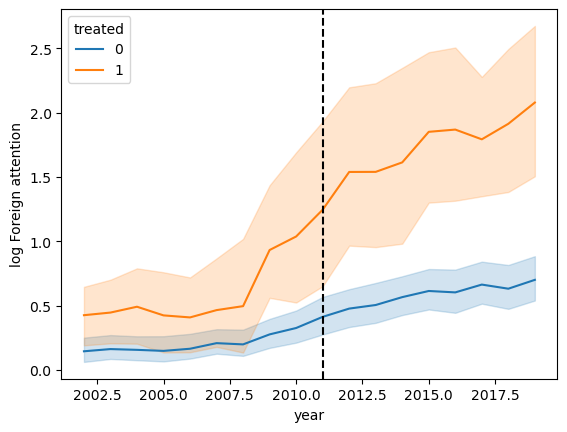

In [37]:
sns.lineplot(data=df_complete, x='year', y='log_count', hue='treated')
plt.axvline(2011, color='k', linestyle='--')
plt.ylabel('log Foreign attention')